In [1]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime

In [2]:
conn = sqlite3.connect('dataset/web-performance-youtube-merged.db')

In [8]:
#conn = sqlite3.connect('web-performance-youtube-two-videos.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements
#conn.close()

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error
0,f3deb725-0a56-a6d8-71c1-fc134714f4c7,-1,-1.000000e+00,-1.000000e+00,tls,34.101.136.158,aqz-KE-bpKQ,Africa South,2022-04-18 00:00:05.342675,auto,1280,720,0,5,aqz-KE-bpKQ,1,
1,17915357-f2e4-81b4-acf7-b71255703ed8,1650240030862687634,1.650240e+12,1.650240e+12,tls,34.101.136.158,aqz-KE-bpKQ,Africa South,2022-04-18 00:00:15.296301,auto,1280,720,0,5,aqz-KE-bpKQ,0,
2,3da12ede-1a92-326c-d21e-ae3888de76fd,-1,-1.000000e+00,-1.000000e+00,https,34.101.136.158,aqz-KE-bpKQ,Africa South,2022-04-18 00:00:35.554066,auto,1280,720,0,5,aqz-KE-bpKQ,1,
3,8297db7d-70e2-96ab-3824-ef58929e52d6,1650240061086062376,1.650240e+12,1.650240e+12,https,34.101.136.158,aqz-KE-bpKQ,Africa South,2022-04-18 00:00:45.492315,auto,1280,720,0,5,aqz-KE-bpKQ,0,
4,df70a4fc-0544-d39f-c9cb-ead9f895746b,-1,-1.000000e+00,-1.000000e+00,quic,34.101.136.158,aqz-KE-bpKQ,Africa South,2022-04-18 00:01:05.821507,auto,1280,720,0,5,aqz-KE-bpKQ,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253809,4d828157-98c1-20e7-ac56-0015c06a69c0,1650815779022777603,1.650816e+12,1.650816e+12,quic,168.138.50.5,lqiN98z6Dak,US West,2022-04-24 15:56:08.580162,auto,1280,720,0,5,lqiN98z6Dak,0,
253810,b5334ee9-44f0-6567-9135-43114d62b032,-1,-1.000000e+00,-1.000000e+00,tcp,168.138.50.5,lqiN98z6Dak,US West,2022-04-24 15:56:23.728047,auto,1280,720,0,5,lqiN98z6Dak,1,
253811,1bd2d12f-81cf-c509-c55b-a4cd2cd743ea,1650815799376591574,1.650816e+12,1.650816e+12,tcp,168.138.50.5,lqiN98z6Dak,US West,2022-04-24 15:56:28.753468,auto,1280,720,0,5,lqiN98z6Dak,0,
253812,af3103fa-4ded-f577-770e-8dceab26598b,-1,-1.000000e+00,-1.000000e+00,udp,168.138.50.5,lqiN98z6Dak,US West,2022-04-24 15:56:44.118970,auto,1280,720,0,5,lqiN98z6Dak,1,


In [9]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

In [10]:
measurements['protocol'] = measurements['protocol'].str.upper()

In [11]:
dns_proto_mapping = {'QUIC':'DoQ', 'HTTPS':'DoH', 'TLS':'DoT', 'TCP':'DoTCP', 'UDP':'DoUDP'}
def map_proto_to_dns(x):
    return dns_proto_mapping[x]
measurements['protocol'] = measurements['protocol'].map(map_proto_to_dns)

In [71]:
res_to_quality = {
    "unknown":"auto","256x144":"tiny", "426x240": "small", "640x360": "medium", "854x480": "large",
    "1280x720": "hd720", "1920x1080": "hd1080", "2560x1440": "hd1440", "3840x2160": "hd2160"
}

quality_to_res = {v: k for k, v in res_to_quality.items()}

def map_quality_to_res(quality):
    return quality_to_res[quality]
def map_res_to_quality(resolution):
    return res_to_quality[resolution]

def make_quality_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['auto', 'tiny', 'small', 'medium', 'large', 'hd720', 'hd1080', 'highres', 'hd1440', 'hd2160'])

def make_res_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['256x144', '426x240', '640x360', '854x480', '1280x720', '1920x1080', '2560x1440', '3840x2160'])

In [12]:
pd.set_option('display.max_rows', 100)

In [3]:
measurement_id_to_plot = '8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4'

In [5]:
df_nerd_stats = pd.read_sql_query(f"SELECT * FROM nerd_stats WHERE msm_id = '{measurement_id_to_plot}'", conn)
df_nerd_stats

,time,curr_play_time,bandwidth_kbps,buffer_health_seconds,codecs,dims_and_frames,resolution,network_activity_bytes,msm_id
0,1.650446e+12,0.361622,8867 Kbps,19.73 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 13,854x480@24 / 1280x720@24,1711 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
1,1.650446e+12,0.873940,8867 Kbps,19.23 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 25,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
2,1.650446e+12,1.383540,8867 Kbps,18.73 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 37,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
3,1.650446e+12,1.894514,8867 Kbps,18.23 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 50,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
4,1.650446e+12,2.406255,8867 Kbps,17.73 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 62,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
5,1.650446e+12,2.917475,8867 Kbps,17.23 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 74,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
6,1.650446e+12,3.428395,8867 Kbps,16.73 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 87,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
7,1.650446e+12,3.938512,8867 Kbps,16.23 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 99,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
8,1.650446e+12,4.448595,8867 Kbps,15.73 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 111,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
9,1.650446e+12,4.958879,8867 Kbps,15.23 s,vp09.00.51.08.01.01.01.01.00 (247) / opus (251),1280x720 / 0 dropped of 123,854x480@24 / 1280x720@24,0 KB,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4


In [20]:
df_iframe = pd.read_sql_query(f"SELECT * FROM iframe_api WHERE msm_id = '{measurement_id_to_plot}'", conn)
df_iframe

,time,event_type,buffer_perc,curr_play_time,video_dur,current_quality,available_qualities,msm_id
0,1.650446e+12,PlayerReady,-1.000000,-1.000000,-1.0,-1,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
1,1.650446e+12,PlayerStateCUED,0.000000,0.000000,-1.0,unknown,[],8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
2,1.650446e+12,PlayStartedFromFunction,-1.000000,-1.000000,194.0,-1,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
3,1.650446e+12,PlayerStateBUFFERING,0.000000,0.000000,-1.0,unknown,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
4,1.650446e+12,BufferLogging,0.000000,0.000000,-1.0,unknown,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
5,1.650446e+12,QualityChangeLarge,0.000000,0.000000,-1.0,large,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
6,1.650446e+12,QualityChange720,0.000000,0.000000,-1.0,hd720,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
7,1.650446e+12,PlayerStatePLAYING,0.050207,0.010564,-1.0,hd720,"['hd2160', 'hd1440', 'hd1080', 'hd720', 'large...",8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
8,1.650446e+12,BufferLogging,0.103514,0.727119,-1.0,hd720,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
9,1.650446e+12,BufferLogging,0.103514,1.727088,-1.0,hd720,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4


In [21]:
df_resource = pd.read_sql_query(f"SELECT * FROM page_resources WHERE msm_id = '{measurement_id_to_plot}'", conn)
df_resource

,connectEnd,connectStart,decodedBodySize,domainLookupEnd,domainLookupStart,duration,encodedBodySize,entryType,fetchStart,initiatorType,name,nextHopProtocol,requestStart,responseEnd,responseStart,secureConnectionStart,startTime,transferSize,msm_id
0,80.100000,64.700000,15344,64.700000,61.400001,31.599999,15344,resource,56.900001,css,https://fonts.gstatic.com/s/roboto/v18/KFOmCnq...,h3,81.400001,88.500000,84.800000,65.000000,56.900001,15644,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
1,5031.900001,5031.900001,0,5031.900001,5031.900001,13.299999,0,resource,5031.900001,img,https://www.youtube.com/api/stats/watchtime?ns...,h3,5032.500000,5045.200000,5044.600000,5031.900001,5031.900001,300,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
2,315.200000,315.200000,100,315.200000,315.200000,115.400001,120,resource,315.200000,xmlhttprequest,https://googleads.g.doubleclick.net/pagead/id,h3,315.600000,326.900001,326.200000,315.200000,211.500000,420,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
3,1596.400001,1579.000000,2866,1579.000000,1577.000000,22.400001,2866,resource,1576.500000,css,https://yt3.ggpht.com/ytc/AKedOLT_31fFSD3FWEBn...,h3,1596.500000,1598.900001,1598.500000,1579.200000,1576.500000,3166,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
4,312.700000,312.700000,27599,312.700000,312.700000,4.900001,8102,resource,312.700000,script,https://www.youtube.com/s/player/19eb72e4/play...,h3,313.800000,317.600000,316.600000,312.700000,312.700000,8402,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
5,2352.100000,2352.100000,0,2352.100000,2352.100000,13.000000,0,resource,2352.100000,img,https://www.youtube.com/ptracking?html5=1&vide...,h3,2353.400001,2365.100000,2364.400001,2352.100000,2352.100000,300,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
6,1519.100000,1519.100000,25083,1519.100000,1519.100000,45.900000,14701,resource,1519.100000,fetch,https://www.youtube.com/youtubei/v1/embedded_p...,h3,1519.600000,1565.000000,1564.200000,1519.100000,1519.100000,15001,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
7,0.000000,0.000000,0,0.000000,0.000000,17.500000,0,resource,2351.700000,script,https://www.google.com/js/th/3e7Dt-NND0lfl1CWn...,h3,0.000000,2369.200000,0.000000,0.000000,2351.700000,0,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
8,2351.900001,2351.900001,0,2351.900001,2351.900001,11.099999,0,resource,2351.900001,img,https://www.youtube.com/api/stats/playback?ns=...,h3,2352.700000,2363.000000,2362.500000,2351.900001,2351.900001,300,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
9,279.000000,279.000000,120879,279.000000,279.000000,6.700000,37497,resource,279.000000,script,https://www.youtube.com/s/player/19eb72e4/play...,h3,279.600000,285.700000,283.100000,279.000000,279.000000,37797,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4


In [55]:
df_web_perf = pd.read_sql_query(f"SELECT msm_id, connectStart, connectEnd, loadEventStart, timeOrigin FROM web_performance_metrics WHERE msm_id = '{measurement_id_to_plot}'", conn)
df_web_perf['plt'] = df_web_perf['loadEventStart'] + df_web_perf['timeOrigin']
df_web_perf['plt'] = pd.to_datetime(df_web_perf['plt'], unit='ms', origin='unix')
df_web_perf['conn_start'] = df_web_perf['connectStart'] + df_web_perf['timeOrigin']
df_web_perf['conn_start'] = pd.to_datetime(df_web_perf['conn_start'], unit='ms', origin='unix')
df_web_perf['conn_end'] = df_web_perf['connectEnd'] + df_web_perf['timeOrigin']
df_web_perf['conn_end'] = pd.to_datetime(df_web_perf['conn_end'], unit='ms', origin='unix')
df_web_perf['timeOrigin'] = pd.to_datetime(df_web_perf['timeOrigin'], unit='ms', origin='unix')
df_web_perf


,msm_id,connectStart,connectEnd,loadEventStart,timeOrigin,plt,conn_start,conn_end
0,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,25.1,25.5,501.8,2022-04-20 09:10:38.806700032,2022-04-20 09:10:39.308499968,2022-04-20 09:10:38.831800064,2022-04-20 09:10:38.832199936


In [72]:
df_dns_perf_metrics = pd.read_sql_query(f"SELECT * FROM dns_metrics WHERE msm_id = '{measurement_id_to_plot}'", conn)

df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].replace({'metrics:DoUDP UDP setup duration from': 'metrics:DoUDP UDP setup duration from '}, regex=True)

df_dns_perf_metrics['metric_type'] = "none"
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("setup duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("exchange duration"), "exchange", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("query duration"), "query", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("handshake duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("DoH query"), "lazy-init-handshake-and-query", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics.metric.str.split(' ').str[-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-2]

df_dns_perf_metrics['base'] = 1000
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'm', 1, df_dns_perf_metrics['base'])
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics['base'])

df_dns_perf_metrics['duration'] = np.where((df_dns_perf_metrics.duration.str[-1] != 'm') & (df_dns_perf_metrics.duration.str[-1] != 'µ'), df_dns_perf_metrics['duration']+'s', df_dns_perf_metrics['duration'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].astype(float) * df_dns_perf_metrics['base']

df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].str[8:]

df_dns_perf_metrics['metric_start'] = df_dns_perf_metrics['metric'].str.extract(r'\sfrom\s(.*?)\sto\s')

df_dns_perf_metrics['metric_end'] = df_dns_perf_metrics['metric'].str.extract(r'\sto\s(.*?)\:\s')

df_dns_perf_metrics['protocol'] = df_dns_perf_metrics.metric.str.split(' ').str[0]

df_dns_perf_metrics['domain'] = df_dns_perf_metrics['metric'].str.extract(r'\sfor\s\[\;(.*?)\]\s')

df_dns_perf_metrics.metric_start = "2022 "+df_dns_perf_metrics.metric_start
df_dns_perf_metrics.metric_end = "2022 "+df_dns_perf_metrics.metric_end

df_dns_perf_metrics.metric_start = pd.to_datetime(df_dns_perf_metrics.metric_start, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.metric_end = pd.to_datetime(df_dns_perf_metrics.metric_end, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.domain = df_dns_perf_metrics.domain.str[:-7]

In [73]:
df_dns_perf_metrics

,msm_id,metric,metric_type,duration,base,metric_start,metric_end,protocol,domain
0,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ QUIC handshake duration from Apr 20 09:10:...,handshake,2.933925,1.0,2022-04-20 09:10:38.852,2022-04-20 09:10:38.855,DoQ,NaN
1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ query duration for [;www.youtube.com.\tIN\...,query,1.258171,1.0,2022-04-20 09:10:38.855,2022-04-20 09:10:38.856,DoQ,www.youtube.com
2,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ exchange duration for [;www.youtube.com.\t...,exchange,4.661625,1.0,2022-04-20 09:10:38.852,2022-04-20 09:10:38.856,DoQ,www.youtube.com
3,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ query duration for [;fonts.gstatic.com.\tI...,query,1.271829,1.0,2022-04-20 09:10:38.986,2022-04-20 09:10:38.987,DoQ,fonts.gstatic.com
4,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ exchange duration for [;fonts.gstatic.com....,exchange,1.440030,1.0,2022-04-20 09:10:38.986,2022-04-20 09:10:38.987,DoQ,fonts.gstatic.com
5,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ query duration for [;googleads.g.doublecli...,query,1.085649,1.0,2022-04-20 09:10:39.136,2022-04-20 09:10:39.137,DoQ,googleads.g.doubleclick.net
6,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ exchange duration for [;googleads.g.double...,exchange,1.230512,1.0,2022-04-20 09:10:39.136,2022-04-20 09:10:39.137,DoQ,googleads.g.doubleclick.net
7,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ query duration for [;static.doubleclick.ne...,query,1.186716,1.0,2022-04-20 09:10:39.142,2022-04-20 09:10:39.143,DoQ,static.doubleclick.net
8,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ exchange duration for [;static.doubleclick...,exchange,1.337662,1.0,2022-04-20 09:10:39.142,2022-04-20 09:10:39.143,DoQ,static.doubleclick.net
9,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,DoQ query duration for [;jnn-pa.googleapis.com...,query,1.109380,1.0,2022-04-20 09:10:39.181,2022-04-20 09:10:39.182,DoQ,jnn-pa.googleapis.com


In [13]:
measurements[measurements.msm_id == measurement_id_to_plot]

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error,player_dimensions
122077,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,1650445847204905388,1.650446e+12,1.650446e+12,DoQ,94.140.14.49,lqiN98z6Dak,Europe Central,2022-04-20 09:10:38.802350,auto,1280,720,0,5,lqiN98z6Dak,0,,1280x720


In [14]:
type(measurements[measurements.msm_id == measurement_id_to_plot].resource_time_origin.values[0])

numpy.float64

In [22]:
df_nerd_stats['time'] = pd.to_datetime(df_nerd_stats['time'], unit='ms', origin='unix')

df_iframe['time'] = pd.to_datetime(df_iframe['time'], unit='ms', origin='unix')

#df_resource['time'] = pd.to_datetime(df_resource['time'], unit='ms', origin='unix')

In [23]:
df_resource['startTime'] = df_resource['startTime'].astype(float)+measurements[measurements.msm_id == measurement_id_to_plot].resource_time_origin.values[0]

In [203]:
df_resource_starts = df_resource[['startTime']]

In [27]:
df_nerd_stats['buffer_health_seconds'] = df_nerd_stats['buffer_health_seconds'].str.replace(r' s$', '')
df_nerd_stats['buffer_health_seconds'] = df_nerd_stats['buffer_health_seconds'].astype(float)

/tmp/ipykernel_713/4279217330.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_nerd_stats['buffer_health_seconds'] = df_nerd_stats['buffer_health_seconds'].str.replace(r' s$', '')


<AxesSubplot:xlabel='time'>

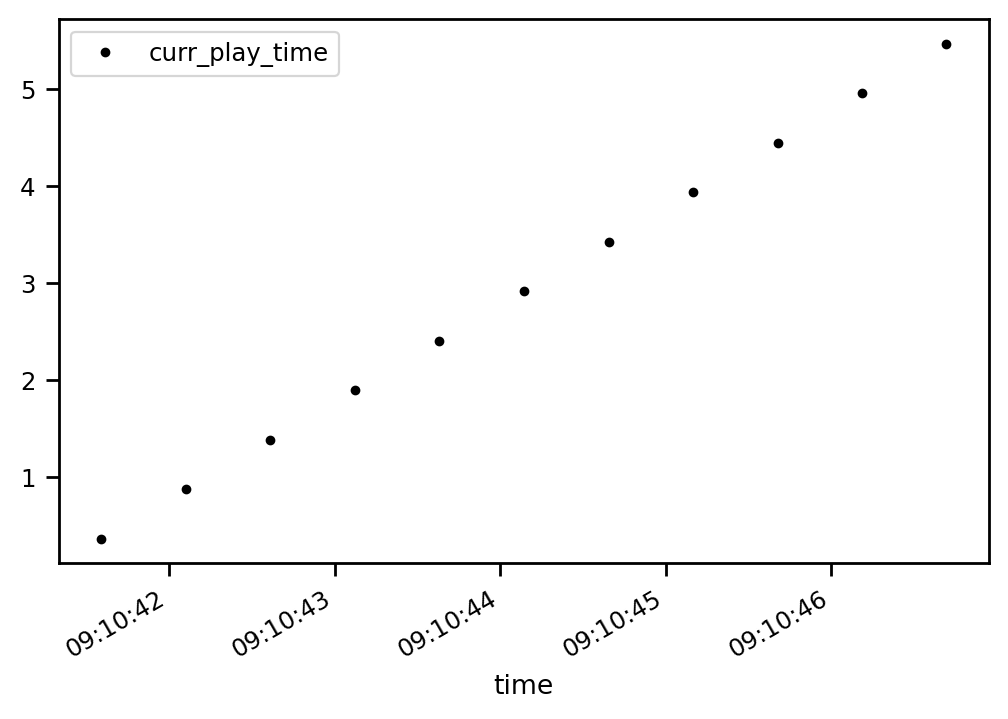

In [28]:
df_nerd_stats[['time', 'curr_play_time']].copy().set_index('time').plot(marker=".", markersize=5, drawstyle="default", lw=0)

<AxesSubplot:xlabel='time'>

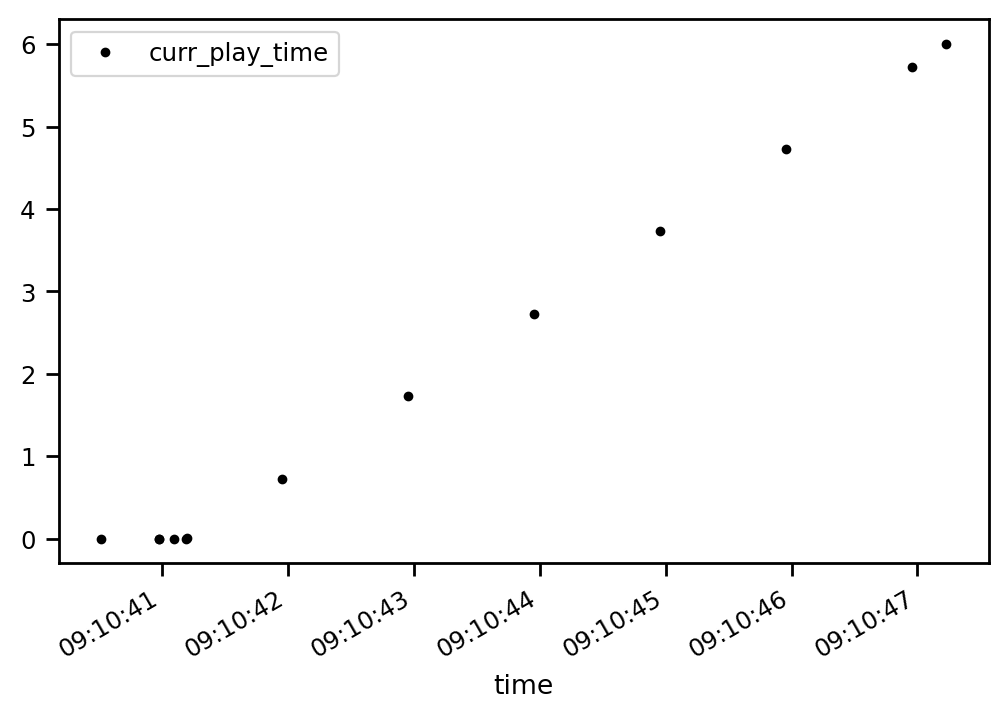

In [29]:
df_iframe[df_iframe.curr_play_time >= 0][['time', 'curr_play_time']].copy().set_index('time').plot(marker=".", markersize=5, drawstyle="default", lw=0)

<AxesSubplot:xlabel='time'>

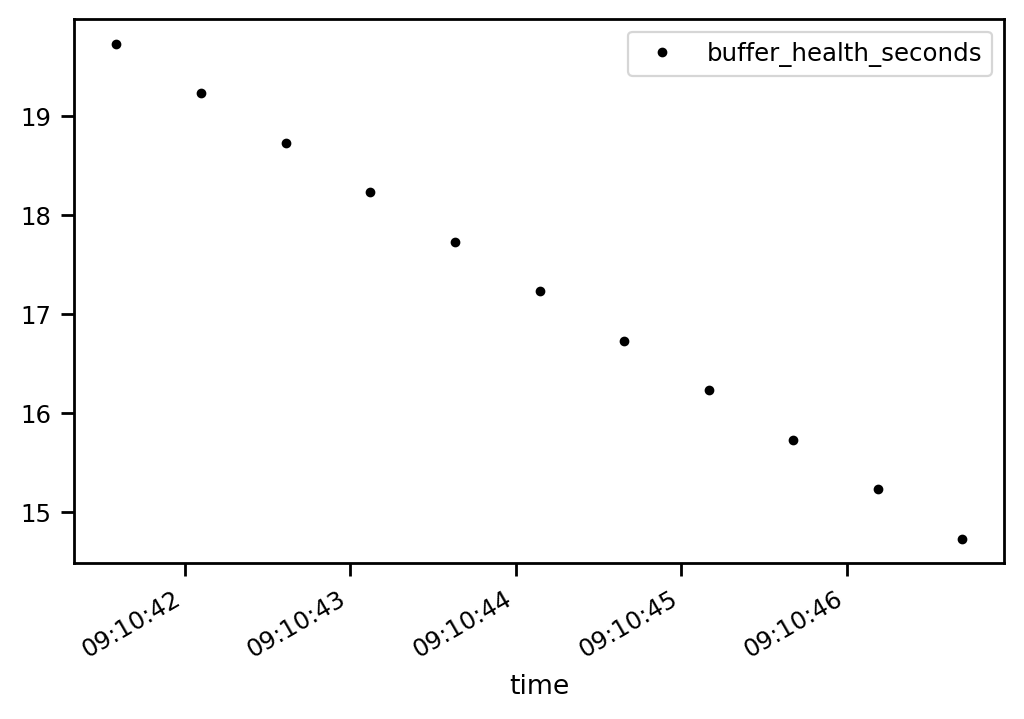

In [30]:
df_buffer_health = df_nerd_stats[['time', 'buffer_health_seconds']].copy().set_index('time')
df_buffer_health.plot(marker=".", markersize=5, drawstyle="default", lw=0)

<AxesSubplot:xlabel='time'>

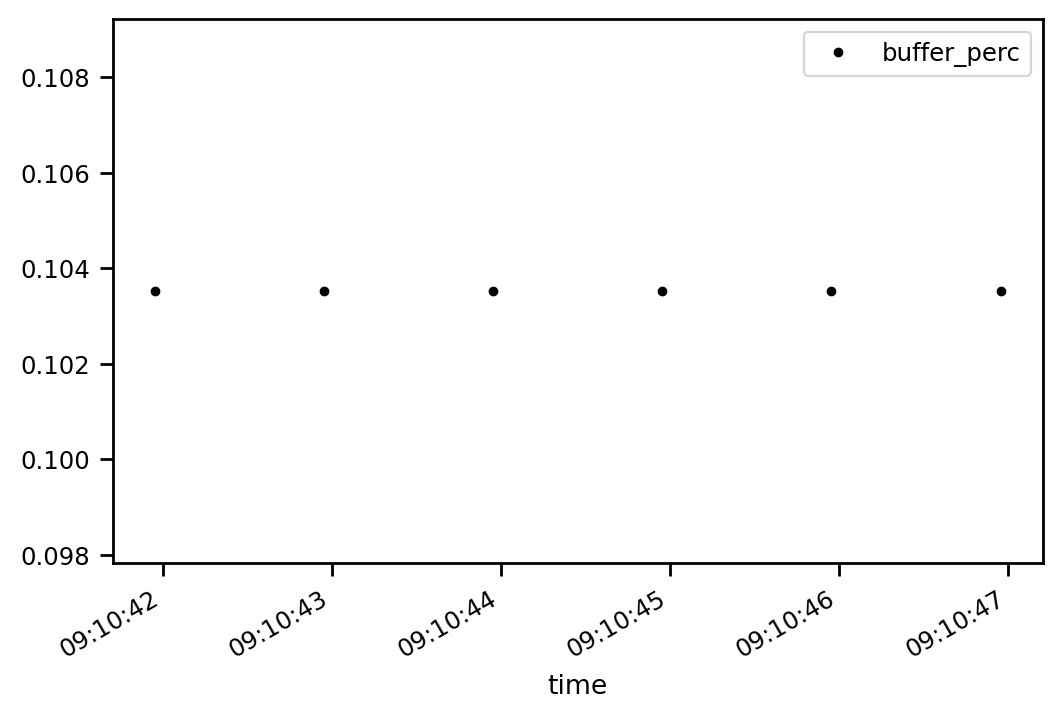

In [31]:
df_buffer_perc = df_iframe[(df_iframe.event_type == 'BufferLogging') & (df_iframe.buffer_perc > 0.)][['time', 'buffer_perc']].copy().set_index('time')
df_buffer_perc.plot(marker=".", markersize=5, drawstyle="default", lw=0)

In [86]:
df_resource[df_resource.name.str.contains('googlevideo.com')].name.values

array(['https://r5---sn-o097znsk.googlevideo.com/videogoodput?id=o-AOyum_KIBXWOgB8FtfjgeUb_DJATwgpnWetoyEVvCjc-&source=goodput&range=0-4999&expire=1650449440&ip=3.70.11.248&ms=pm&mm=35&pl=24&nh=IgpwZjAxLnNmbzEwKg4yMTMuMjQ4LjEwMC41Ng&sparams=id,source,range,expire,ip,ms,mm,pl,nh&signature=836570BA15DF185B3741D79F80448086974CABF2.731498D6D88EA0574579963549C33DD4437CE25B&key=cms1&cpn=UVsWCCXbD462-oEV'],
      dtype=object)

In [78]:
df_iframe.sort_values('time')

,time,event_type,buffer_perc,curr_play_time,video_dur,current_quality,available_qualities,msm_id
0,2022-04-20 09:10:39.284800000,PlayerReady,-1.000000,-1.000000,-1.0,-1,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
1,2022-04-20 09:10:40.513999872,PlayerStateCUED,0.000000,0.000000,-1.0,unknown,[],8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
2,2022-04-20 09:10:40.953499904,PlayStartedFromFunction,-1.000000,-1.000000,194.0,-1,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
3,2022-04-20 09:10:40.972800000,PlayerStateBUFFERING,0.000000,0.000000,-1.0,unknown,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
4,2022-04-20 09:10:40.972999936,BufferLogging,0.000000,0.000000,-1.0,unknown,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
5,2022-04-20 09:10:41.096099840,QualityChangeLarge,0.000000,0.000000,-1.0,large,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
6,2022-04-20 09:10:41.194099968,QualityChange720,0.000000,0.000000,-1.0,hd720,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
7,2022-04-20 09:10:41.196000000,PlayerStatePLAYING,0.050207,0.010564,-1.0,hd720,"['hd2160', 'hd1440', 'hd1080', 'hd720', 'large...",8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
8,2022-04-20 09:10:41.954200064,BufferLogging,0.103514,0.727119,-1.0,hd720,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4
9,2022-04-20 09:10:42.954200064,BufferLogging,0.103514,1.727088,-1.0,hd720,-1,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4


In [87]:
measurements[measurements.msm_id == measurement_id_to_plot]

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error,player_dimensions
122077,8933c2f1-e2fd-9cf6-9d2a-39d28126b0a4,1650445847204905388,1.650446e+12,1.650446e+12,DoQ,94.140.14.49,lqiN98z6Dak,Europe Central,2022-04-20 09:10:38.802350,auto,1280,720,0,5,lqiN98z6Dak,0,,1280x720


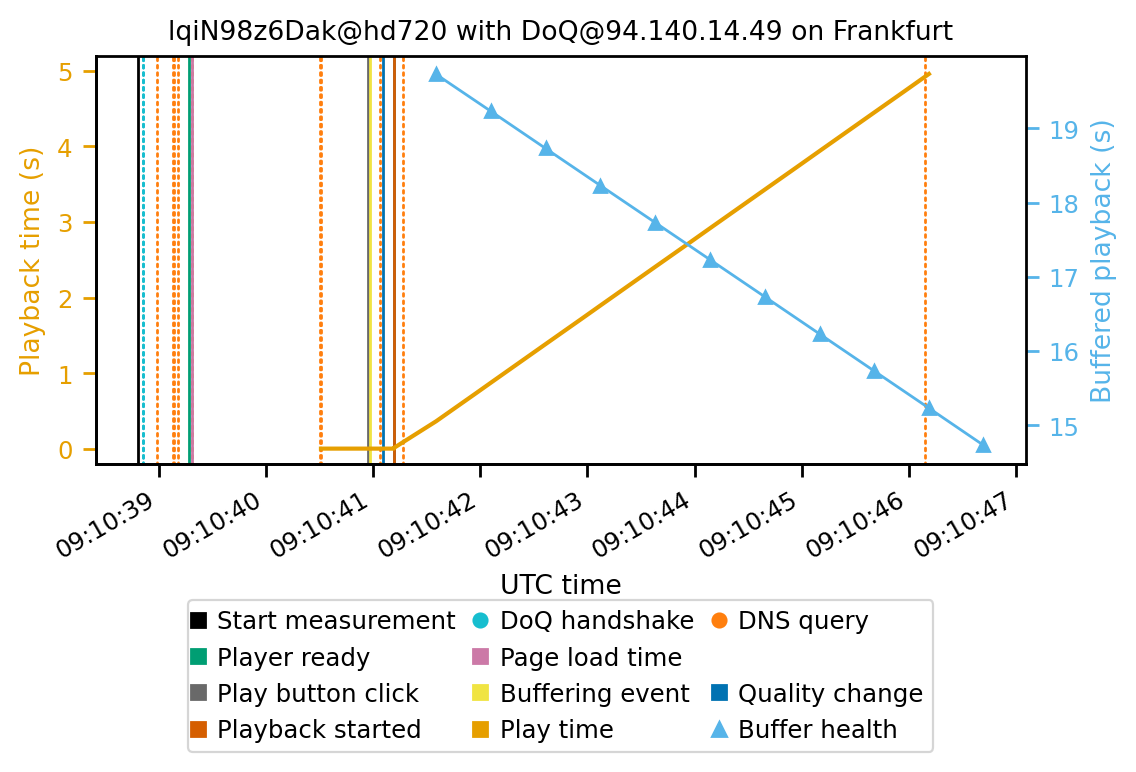

In [166]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
#dfplt.plot(y="query_name", ax=ax2, label="Fastly IPv6", marker=".", markersize=mrksize, drawstyle="default", color='C0', lw=0)
#df_iframe[df_iframe.curr_play_time >= 0][['time', 'curr_play_time']].copy().set_index('time').plot(ax=ax, marker=".", markersize=5, drawstyle="default", lw=0)
#df_nerd_stats[['time', 'curr_play_time']].copy().set_index('time').plot(ax=ax, marker=".", markersize=5, drawstyle="default", lw=0)
df_tmp = pd.concat([df_iframe[(df_iframe.curr_play_time >= 0) & (df_iframe.curr_play_time < 5)][['time', 'curr_play_time']].copy(), df_nerd_stats[(df_nerd_stats.curr_play_time < 5)][['time', 'curr_play_time']].copy()]).set_index('time')
df_tmp.plot(ax=ax, marker=".", markersize=0, drawstyle="default", lw=1.5, color='C1')

#color_map = {'Play time':'C1','Buffer health':'C2', 'Play button click':'black', 'Player ready':'C3', 'Stall event':'C4', 
            #'Playback started':'C6', 'Quality change':'C5', 'Start msm':'tab:purple', 'Page load time': 'C7', 'DoQ handshake':'tab:cyan', 'DNS resolutions':'tab:orange'}
    
color_map = {'Start measurement':'black', 'DoQ handshake':'tab:cyan', 'DNS query':'tab:orange', 'Player ready':'C3', 'Page load time': 'C7', '':'None',
            'Play button click':'dimgray', 'Buffering event':'C4', 'Quality change':'C5', 'Playback started':'C6', 'Play time':'C1','Buffer health':'C2'}

#https://stackoverflow.com/a/48127302
#pandas uses 64bit ints to represent a date, plotting converts them to 32bit -> this may fail
buffer_events_list = [datetime.fromtimestamp(dt.timestamp()) for dt in df_iframe[df_iframe.event_type == 'PlayerStateBUFFERING'].time]

line = ax.vlines(x=pd.to_datetime(df_dns_perf_metrics[(df_dns_perf_metrics.metric_type == 'exchange') & (df_dns_perf_metrics.domain != 'www.youtube.com')].metric_start), ymin=-1, ymax=6, colors='tab:orange', lw=1, ls='dotted', capstyle='round')

_ = ax.vlines(x=df_iframe[df_iframe.event_type == 'PlayerReady'].time.values[0], ymin=-1, ymax=6, colors='C3', lw=1, ls='solid')
_ = ax.vlines(x=df_iframe[df_iframe.event_type == 'PlayStartedFromFunction'].time.values[0], ymin=-1, ymax=6, colors='dimgray', lw=1, ls='solid')
_ = ax.vlines(x=pd.to_datetime(df_iframe[df_iframe.event_type.str.startswith('QualityChange')].time), ymin=-1, ymax=6, colors='C5', lw=1, ls='solid')
_ = ax.vlines(x=pd.to_datetime(df_iframe[df_iframe.event_type == 'PlayerStateBUFFERING'].time), ymin=-1, ymax=6, colors='C4', lw=1, ls='solid')
_ = ax.vlines(x=pd.to_datetime(df_iframe[df_iframe.event_type == 'PlayerStatePLAYING'].time), ymin=-1, ymax=6, colors='C6', lw=1, ls='solid')
#_ = ax.vlines(x=list(pd.to_datetime(df_iframe[df_iframe.event_type == 'QualityChange2160'].sort_values('time').time))[0], ymin=-1, ymax=31, colors='C5', lw=1, )
#ax.text(list(pd.to_datetime(df_iframe[df_iframe.event_type == 'QualityChange2160'].sort_values('time').time))[0], 15, "optimal quality reached", rotation=90, verticalalignment='center', color='C0', size='xx-small')
_ = ax.vlines(x=pd.to_datetime(df_web_perf.plt), ymin=-1, ymax=6, colors='C7', lw=1, ls='solid')
_ = ax.vlines(x=pd.to_datetime(df_web_perf.timeOrigin), ymin=-1, ymax=6, colors='black', lw=1, ls='solid')

_ = ax.vlines(x=pd.to_datetime(df_dns_perf_metrics[df_dns_perf_metrics.metric_type == 'handshake'].metric_start), ymin=-1, ymax=6, colors='tab:cyan', lw=1, ls='dotted', capstyle='round')
_ = ax.vlines(x=pd.to_datetime(df_dns_perf_metrics[df_dns_perf_metrics.metric_type == 'handshake'].metric_end), ymin=-1, ymax=6, colors='tab:cyan', lw=1, ls='dotted', capstyle='round')



#_ = ax.vlines(x=pd.to_datetime(df_iframe[df_iframe.event_type == 'PlayerStateCUED'].time), ymin=-1, ymax=6, colors='tab:orange', lw=1, ls='solid')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.spines['left'].set_position(('axes', -0.0))
ax.tick_params(axis='y', colors='C1')
ax.yaxis.label.set_color('C1')

ax.set_title("lqiN98z6Dak@hd720 with DoQ@94.140.14.49 on Frankfurt")

ax.set_xlabel("UTC time")
ax.set_ylabel('Playback time (s)')
ax.set_ylim(-0.2,5.2)

ax2 = ax.twinx()
df_buffer_health.plot(ax=ax2, marker="^", markersize=4, drawstyle="default", lw=1, color='C2')
#ax2.spines['right'].set_color('C2')
ax2.yaxis.label.set_color('C2')
ax2.tick_params(axis='y', colors='C2')
ax2.set_ylabel('Buffered playback (s)')

ax.legend_.remove()
ax2.legend_.remove()

order = [0,3,6,9,1,4,7,10,2,5,8,11]
markers = dict(zip(color_map.keys(), ['s' if ((legend_item != 'DNS query') and (legend_item != 'DoQ handshake')) else 'o' for legend_item in color_map.keys()]))
markers['Buffer health'] = '^'
legend_elements = [mpl.lines.Line2D([0], [0], color=color_map[legend_item], lw=0, label=legend_item, marker=markers[legend_item]) for legend_item in color_map.keys()]

plt.gca().legend(handles=[legend_elements[idx] for idx in order], loc='center', ncol=3, bbox_to_anchor=(.5, -.52), columnspacing=1, handlelength=0)

plt.show()

fig.savefig('figures/video_timeline.pdf', format='pdf', bbox_inches='tight')